In [1]:
import os
import sys
sys.path.append('/home/kevinteng/Desktop/DE_Project')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from coord_conv import CoordConv
import cv2
import utils
import utils_vis
import utils_model
from sklearn.model_selection import train_test_split
from utils_vis import plot_comparison
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
from random import randint, seed
from utils import stack4plot, similarity_multi, similarity_multiplication
from utils_vis import overlapMasks, overlapMasks02

/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-package

In [2]:
def min_max_norm(images, norm_axis = 'channel_wise'):
    """
    Min max normalization of images
    Parameters:
        images: Input stacked image list
        norm_axis: axis where the normalize should be computed,
            'channel_wise': min max norm along the channel
            'frame_wise': min max norm frame wise
    Return:
        Image list after min max normalization
    """
    assert norm_axis=='channel_wise' or norm_axis=='frame_wise',\
    "Please input 'channel_wise' or 'frame_wise'"
    if norm_axis == 'channel_wise':
        m = np.max(images) #max val along the channel
        mi = np.min(images) #min val along the channel
        output = (images - mi)/ (m - mi)
    elif norm_axis == 'frame_wise':
        #tile the tensor with respect to input image
        # so that the substaction with max and min val can be broadcasted
        tile_coef = tf.constant([1,100,100,1], tf.int32)
        #tile max
        #reduce max val along the axis 1 & 2 
        #(images.shape[0], 1, 1,1) images.shape[0]=>max val per frames
        max_tensor = tf.reshape(tf.math.reduce_max(tf.math.reduce_max(images, 1),1), (-1,1,1,1))
        tile_max = tf.tile(max_tensor, tile_coef)
        #tile min
        #reduce min val along the axis 1 & 2 
        #(images.shape[0], 1, 1,1) images.shape[0]=>min val per frames
        min_tensor = tf.reshape(tf.math.reduce_min(tf.math.reduce_min(images, 1),1), (-1,1,1,1))
        tile_min = tf.tile(min_tensor, tile_coef)
        #compute min max frame wise
        output = (images-tile_min)/(tile_max-tile_min)
    return output

def plot_histogram(images, bins=20):
    #plot historgram for min max norm image
    plt.hist(tf.reshape(images, [-1]),bins,[0,1])
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.show()

Image size:  100


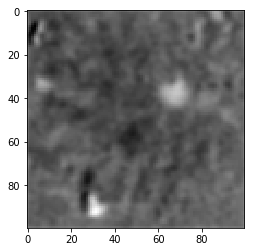

In [3]:
dataset = np.load('/home/kevinteng/Desktop/jpg_to_npy_benchmark/DG13_3-8-17_preprocessed_dF.npy')

NEW_SIZE = 100
#re_list = dataset
re_list = utils.resize(dataset, NEW_SIZE)
IMG_SIZE = re_list.shape[1]

print('Image size: ', IMG_SIZE)
#Dimension for network should include the color channel 
re_list = np.expand_dims(re_list, axis = -1)
#Cast data type to float32 for TensorFlow
# re_list = re_list.astype('float32')
re_list = tf.convert_to_tensor(re_list, dtype = tf.float32)

for img in re_list:
    plt.imshow(np.reshape(img, (IMG_SIZE, IMG_SIZE)), cmap = 'gray')
    plt.show()
    
    break
    
#     if input()=='exit':
#         break

In [4]:
#channel wise min max norm
channel_mm = min_max_norm(re_list, norm_axis = 'channel_wise')
#frame wise min max norm
frame_mm = min_max_norm(re_list, norm_axis = 'frame_wise')

In [8]:
print(np.mean(channel_mm))
print(np.mean(frame_mm))

0.35513562
0.34916472


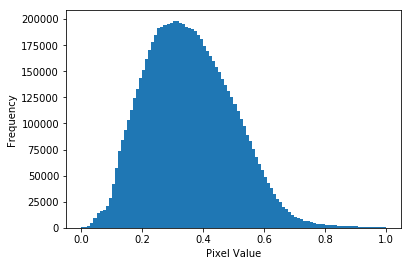

In [5]:
#historgram for channel min max
plot_histogram(channel_mm, bins=100)

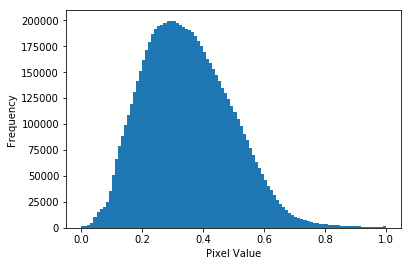

In [6]:
#histogram for frame min max
plot_histogram(frame_mm, bins=100)

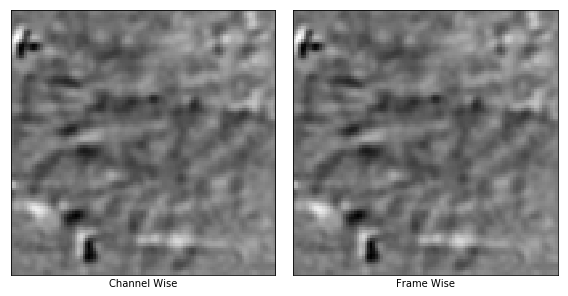

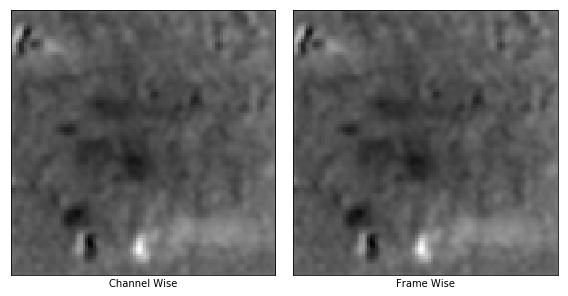

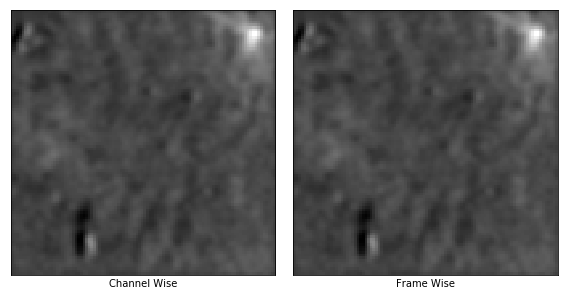

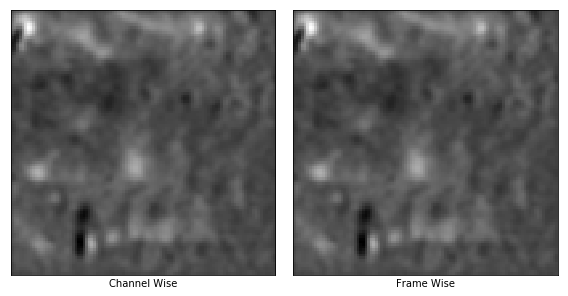

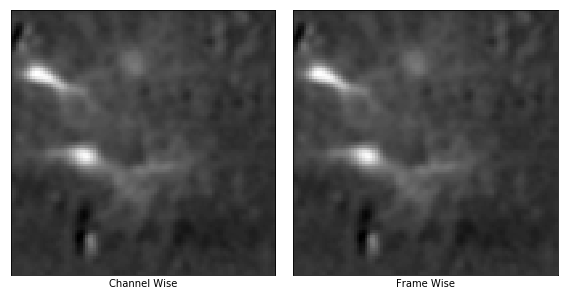

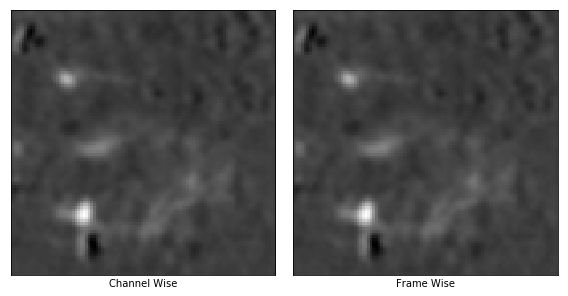

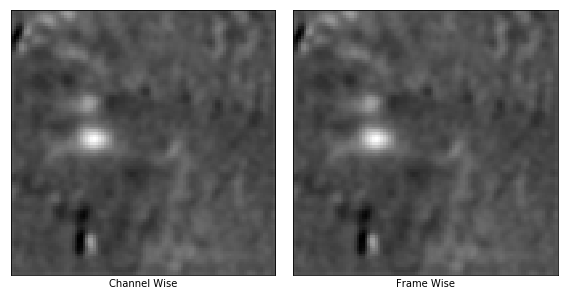

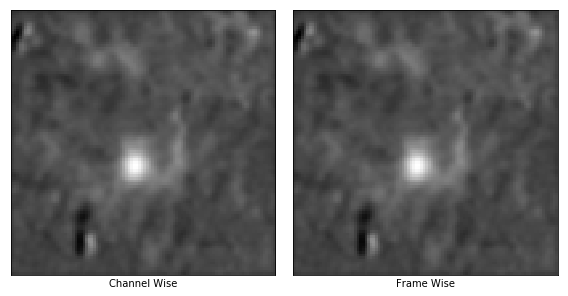

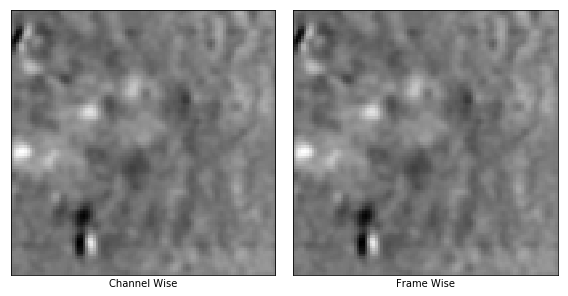

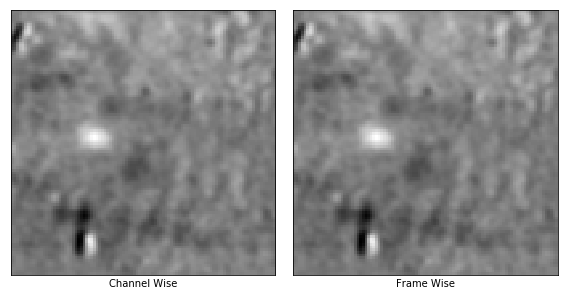

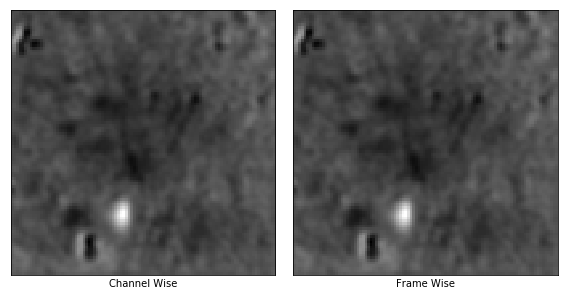

In [7]:
steps=0
while steps<=10:
    rand = np.random.randint(re_list.shape[0])
    img_row01 = [channel_mm[rand],frame_mm[rand]]
    captions_01 = ['Channel Wise', 'Frame Wise']
    plot_comparison(img_row01, captions_01, n_col=len(img_row01), figsize = (8, 8))
    steps+=1